In [148]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
%config InlineBackend.figure_format='retina'

### 1. Load training and testing data
`mnist` : Modified National Institute of Standards and Technology

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
# save for server-test script
# print(list(map(lambda x:list(x),x_test[0])))

### 2. Visualize training data

In [4]:
def show_images(data,labels=[]):
    'given an array of images, plots them'
    n=len(data)
    fig,ax=plt.subplots(ncols=n,figsize=(15,5))
    for i in list(range(n)):
        if n>1:
            ax[i].imshow(data[i],cmap='gray_r')
            ax[i].xaxis.set_visible(False)
            ax[i].yaxis.set_visible(False)
            if (len(labels)>0):
                ax[i].set_title(labels[i])
        else:
            ax.imshow(data[i],cmap='gray_r')
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

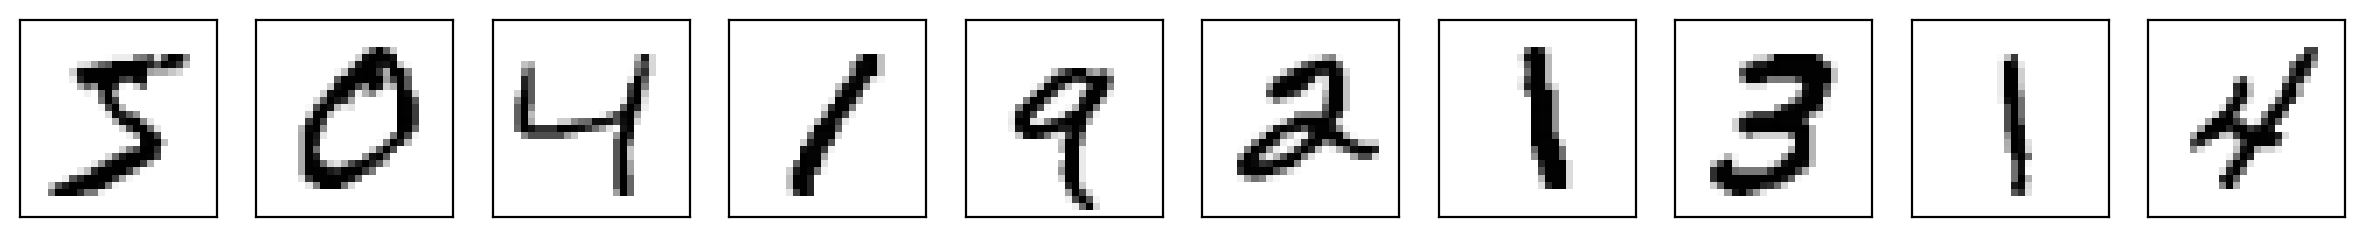

In [5]:
show_images(x_train[:10])

### 3. create model

- `Sequential` is used to stack layers where each layer has one input tensor and one output tensor
- `Flatten` converts multidimensional array to vector : [[1,2,3,4]
[5,6,7,8]] -> [[1,2,3,4,5,6,7,8]]

- `Dense` densely-connected neural network layer

- `Dropout` randomly sets input units to zero with a frequency of rate at each step only during training to help prevent overfitting

In [539]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(10)])
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_61 (Dense)            (None, 128)               100480    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_62 (Dense)            (None, 128)               16512     
                                                                 
 dense_63 (Dense)            (None, 128)               16512     
                                                                 
 dense_64 (Dense)            (None, 10)                1290      
                                                                 
Total params: 134,794
Trainable params: 134,794
Non-t

### 4. compile model

In [540]:
# create loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])

### 5. train model

In [541]:
model.fit(x_train,y_train,epochs=1)

1875/1875 [==============================] - 8s 4ms/step - loss: 0.2537 - accuracy: 0.9231


### 6. evaluate model

In [542]:
print(model.evaluate(x_test,y_test,verbose=2))
print(model.metrics_names)

313/313 - 1s - loss: 0.1354 - accuracy: 0.9580 - 945ms/epoch - 3ms/step
[0.13544540107250214, 0.9580000638961792]
['loss', 'accuracy']


### 7. make predictions

In [543]:
def solve_predictions(predictions):
    return list(map(lambda x: np.where(np.isclose(x,max(x))==True)[0][0],predictions))

In [544]:
predictions=model.predict(x_test[:20])
predicted_labels=solve_predictions(predictions)

1/1 [==============================] - 0s 43ms/step


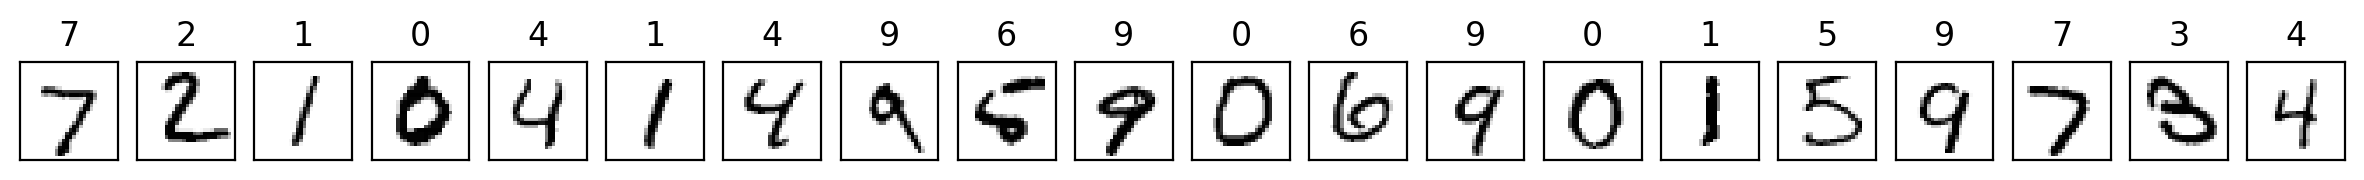

In [545]:
show_images(x_test[:20],predicted_labels)

### 8. save model

In [546]:
tf.keras.Sequential.save(model,'mnist-model')

INFO:tensorflow:Assets written to: mnist-model/assets


### 9. checkout weights

- `get_weights()` returns the weights that connect the input neurons to the output neurons
- in TensorFlow, it is not possible to directly access the weights of an individual neuron; this is because the weights are stored in tensors that represent the entire layer, and not in tensors that represent individual neurons
- to see the weights of an individual neuron, I will need to process the weights to return by-neuron instead of by-input

In [547]:
def plot_weights(weights,input_shape,show_n=False):
    '''
    lighter color indicates more positive activation
    
    ex) 
    test_model=tf.keras.models.Sequential([tf.keras.layers.Input(16),tf.keras.layers.Dense(10)])
    weights=test_model.layers[0].get_weights()[0]
    plot_weights(weights,input_shape=(4,4))
    '''
    
    if not show_n: show_n=weights.shape[1]
        
    ncols=10
    nrows=math.trunc(show_n/10+1)
        
    fig,ax=plt.subplots(ncols=ncols,nrows=nrows,figsize=(15,nrows*1.5),gridspec_kw = {'wspace':0, 'hspace':0})
    fig.set_tight_layout(True)
    for i in list(range(ncols*nrows)):
        r=math.trunc(i/10)
        c=i%10
        if i+1>show_n:
            if nrows!=1:
                ax[r,c].set_visible(False)
            else:
                ax[c].set_visible(False)
        else:
            if nrows!=1:
                ax[r,c].imshow(weights[:,i].reshape(input_shape),cmap='gray')
                ax[r,c].xaxis.set_visible(False)
                ax[r,c].yaxis.set_visible(False)

                for spine in ax[r,c].spines.values():
                    spine.set_edgecolor('white')
            else:
                ax[c].imshow(weights[:,i].reshape(input_shape),cmap='gray')
                ax[c].xaxis.set_visible(False)
                ax[c].yaxis.set_visible(False)

                for spine in ax[c].spines.values():
                    spine.set_edgecolor('white')

In [548]:
def get_next_layer_weights(layer_1_weights,layer_2_weights):
    '''
    returns the sum of (previous layer's weights transformed by the next layer's weights)
    used to visualize a layer's weights in a meaningful format (in terms of the input)
    where the positions have visual meaning (the image pixels) as opposed to being an array
    of features from the previous layer
    
    ex)
    test_model=tf.keras.models.Sequential([tf.keras.layers.Input(16),tf.keras.layers.Dense(10),tf.keras.layers.Dense(5)])
    weights_1=test_model.layers[0].get_weights()[0]
    weights_2=test_model.layers[1].get_weights()[0]
    plot_weights(weights_1,input_shape=(4,4))
    plot_weights(get_next_layer_weights(weights_1,weights_2),input_shape=(4,4))
    '''
    
    layer_1_neurons = list(map(lambda x:layer_1_weights[:,x],list(range(layer_1_weights.shape[1]))))
    layer_2_neurons = list(map(lambda x:layer_2_weights[:,x],list(range(layer_2_weights.shape[1]))))
    
    output=np.empty((0,len(layer_1_weights)))
    
    for neuron in layer_2_neurons:
        
        total=0
        
        for previous_neuron,weight in zip(layer_1_neurons,neuron):
            total+=previous_neuron*weight
    
        output=np.append(output,[total],axis=0)
        
    # convert shape back to form of tensorflow get_weights()
    
    output = np.array(list(map(lambda x:output[:,x],list(range(output.shape[1])))))
        
    return output

In [549]:
dense_1 = model.layers[1].get_weights()[0]
dense_2 = model.layers[3].get_weights()[0]
dense_3 = model.layers[4].get_weights()[0]
dense_4 = model.layers[5].get_weights()[0]

weight_3_hold=get_next_layer_weights(dense_2,dense_3)
weights_3=get_next_layer_weights(dense1,weight_3_hold)

weight_4_hold=get_next_layer_weights(dense_3,dense_4)
weight_4_hold=get_next_layer_weights(dense_2,weight_4_hold)
weights_4=get_next_layer_weights(dense_1,weight_4_hold)

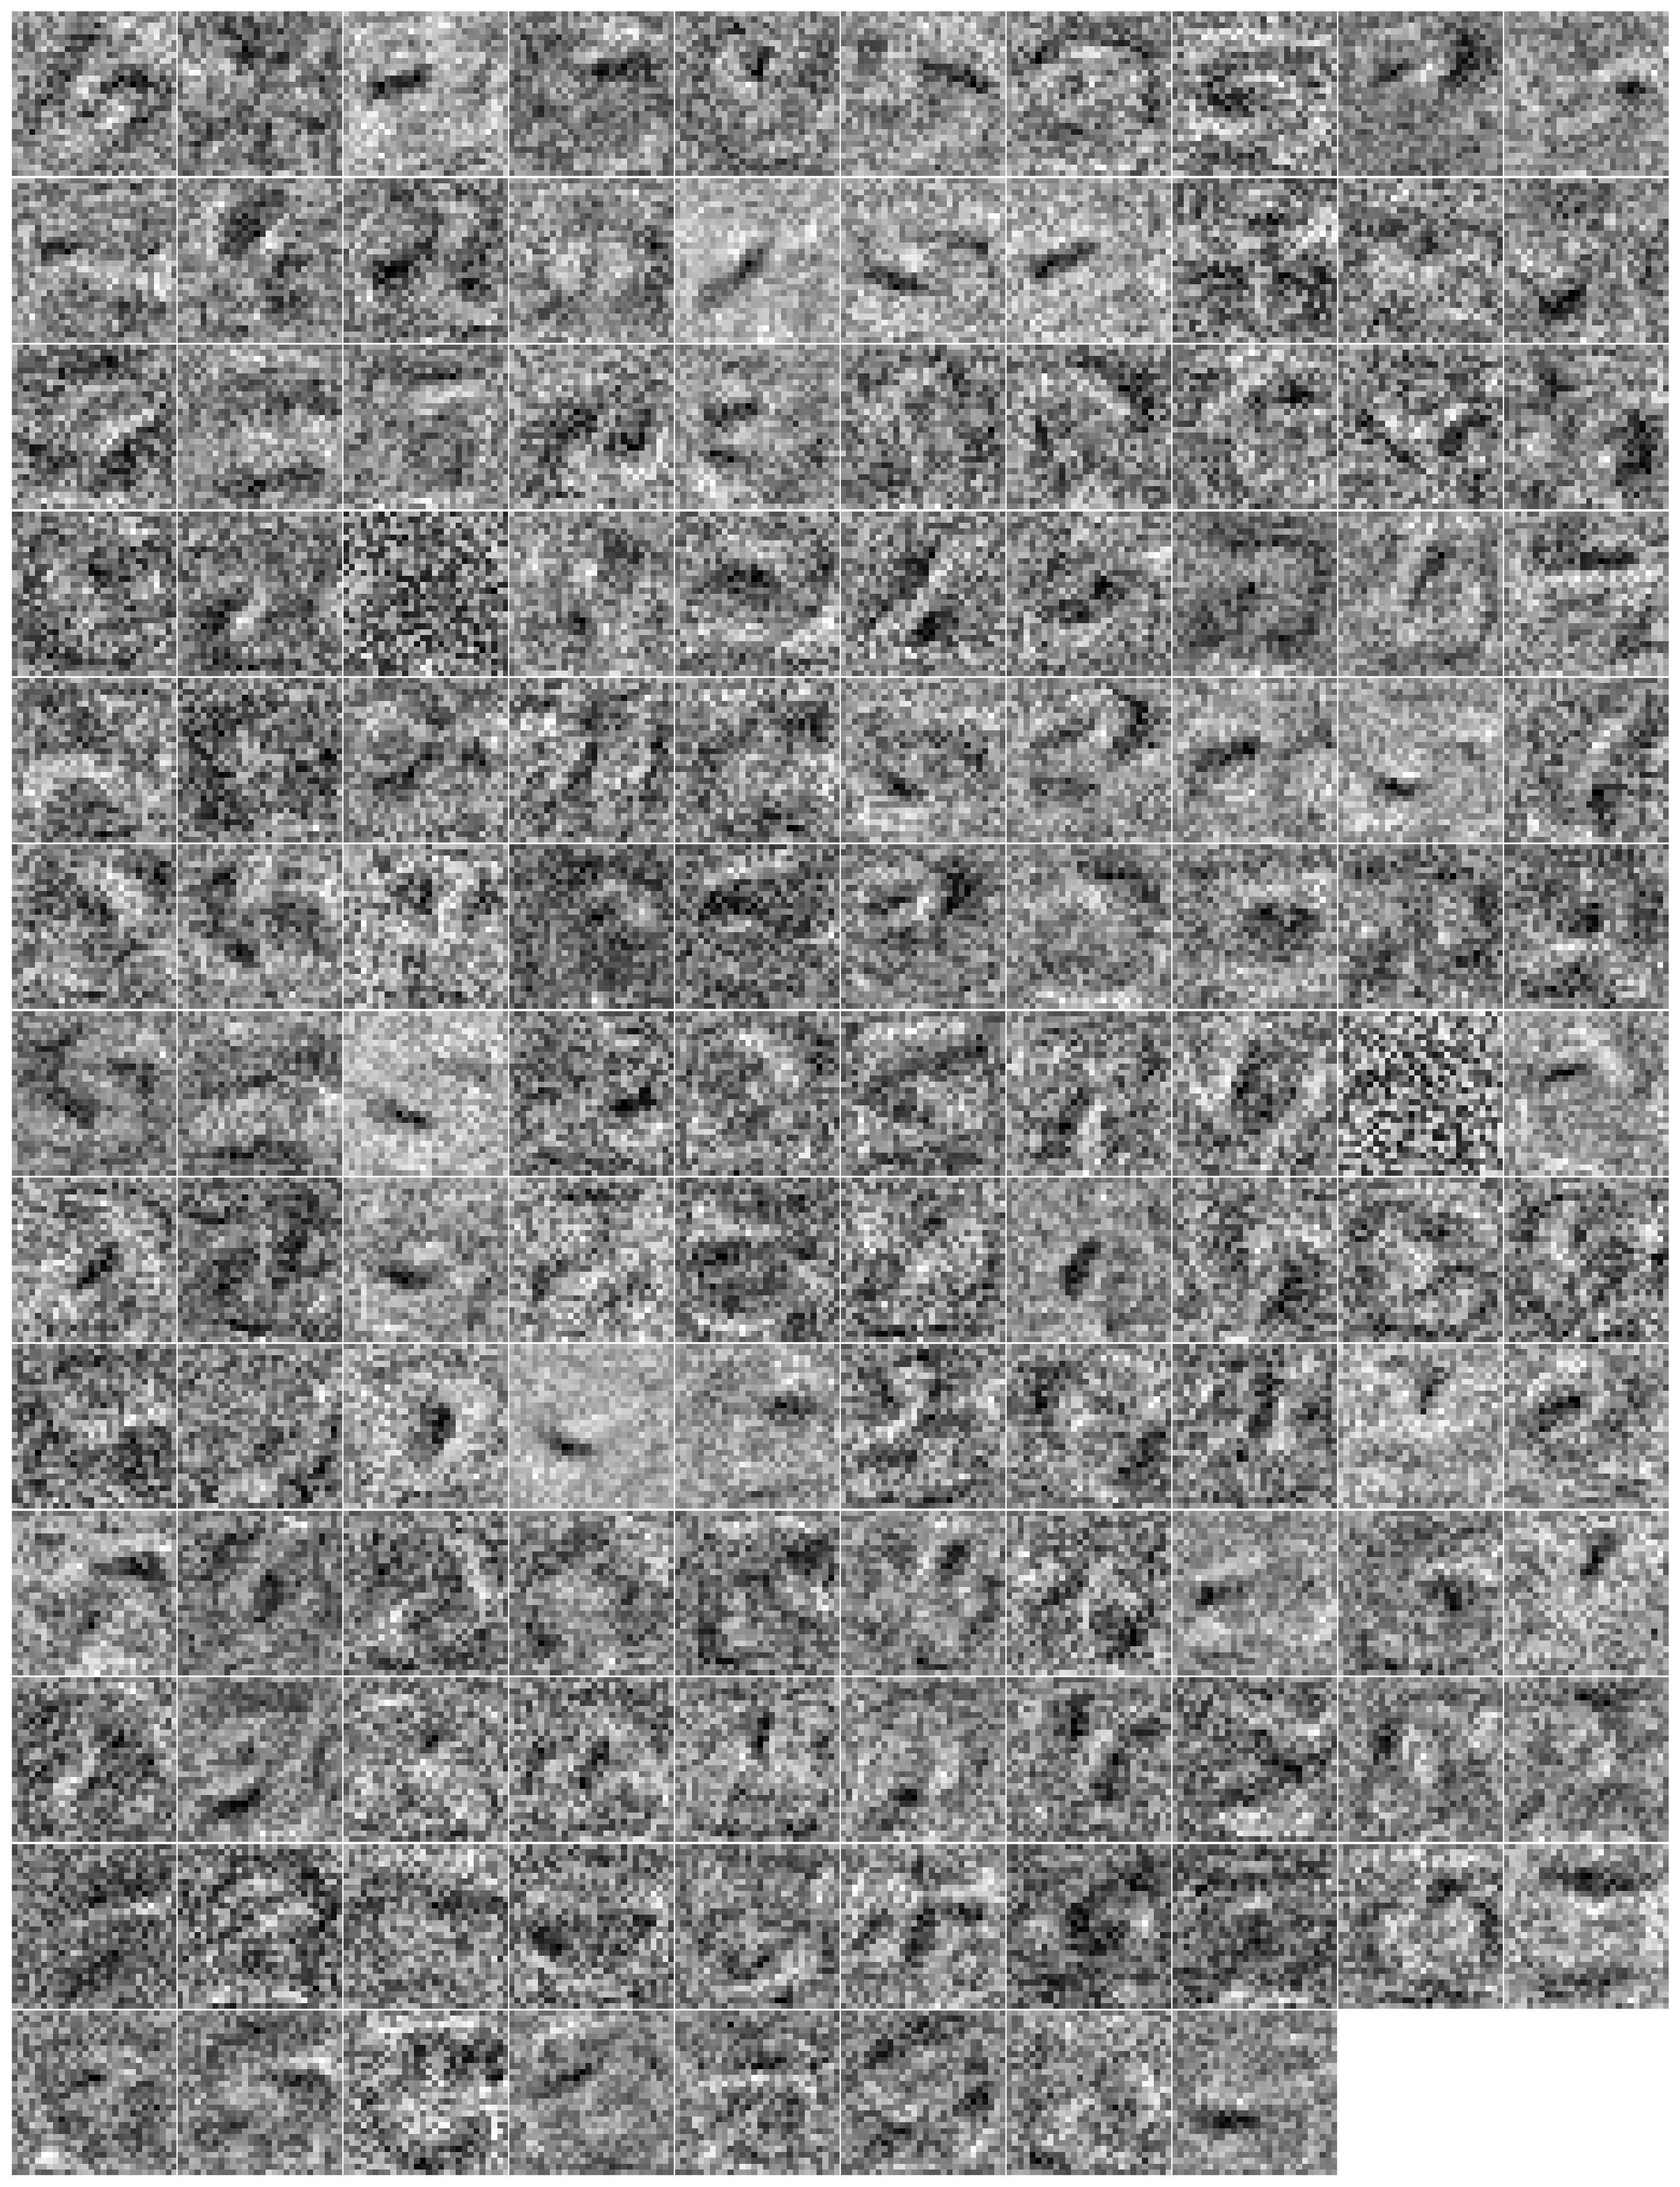

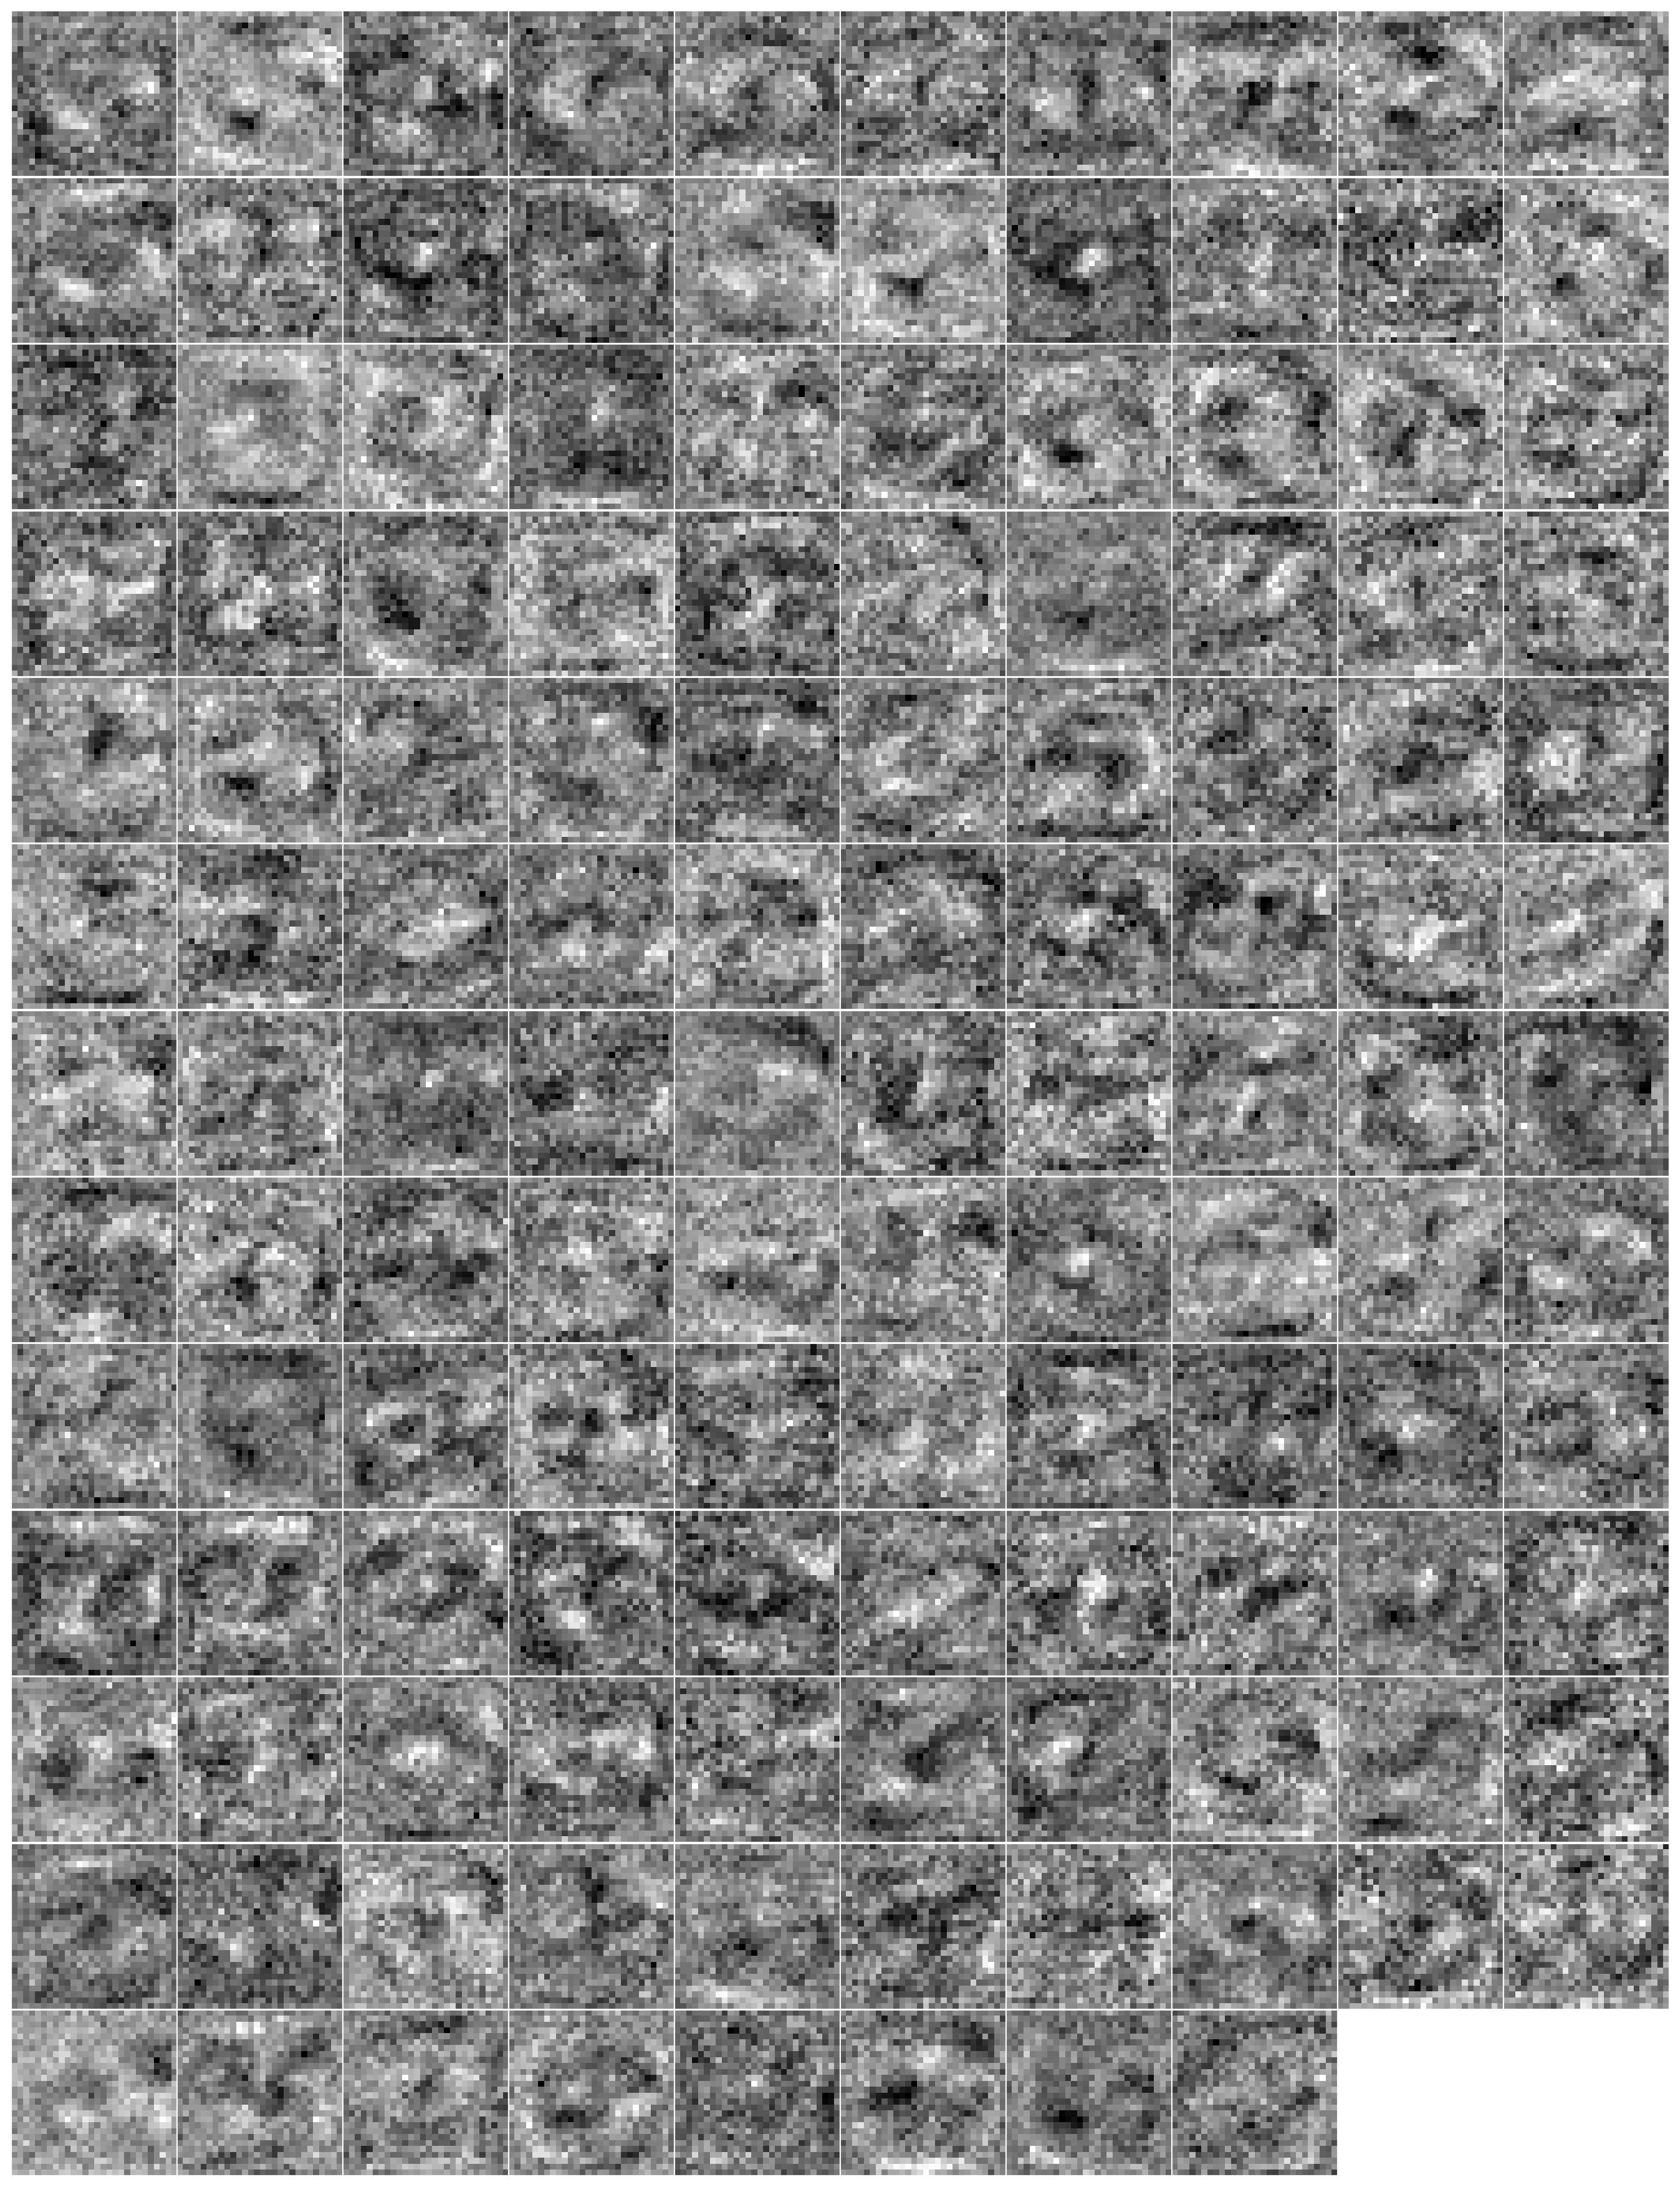

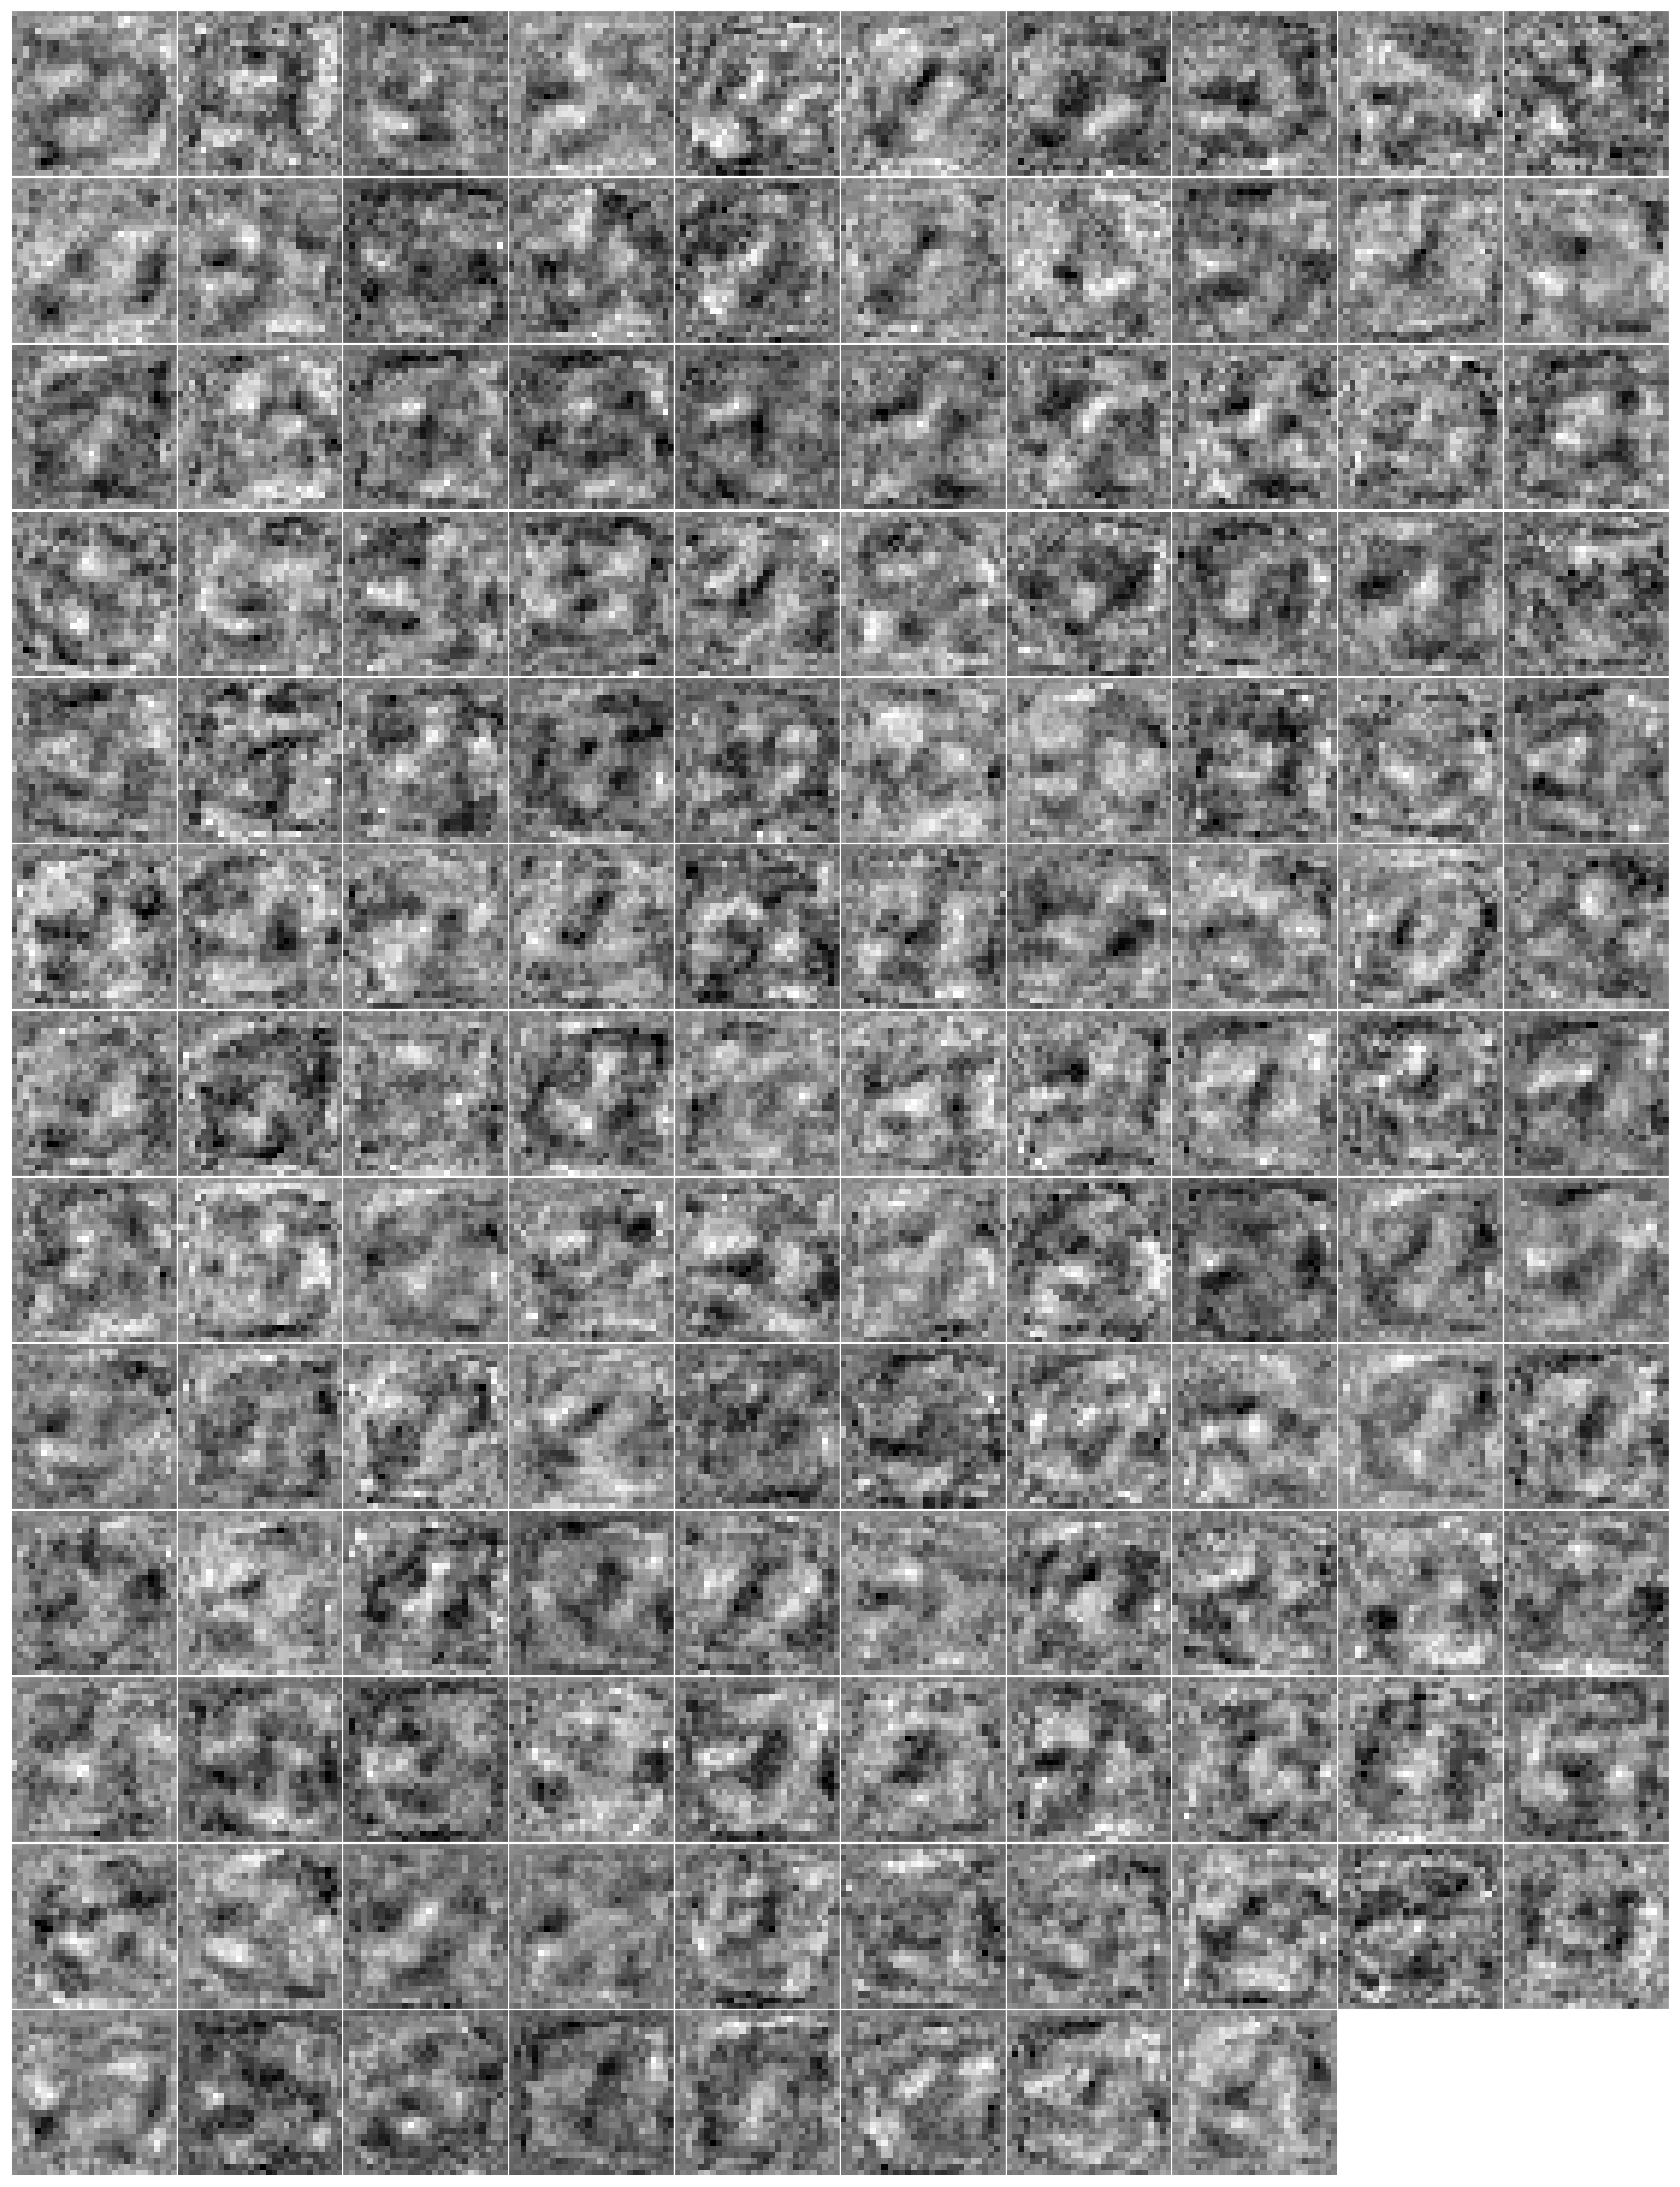

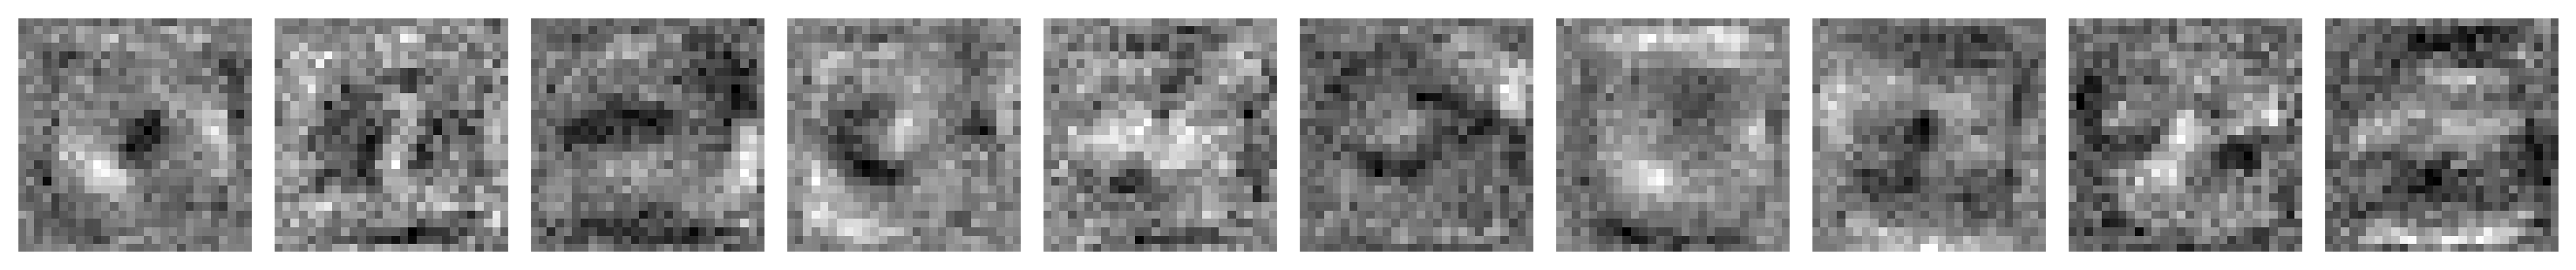

In [550]:
plot_weights(dense_1,input_shape=(28,28),show_n=128)
plot_weights(get_layer_two_weights(dense_1,dense_2),input_shape=(28,28))
plot_weights(weights_3,input_shape=(28,28))
plot_weights(weights_4,input_shape=(28,28))